In [34]:
# =========================================================
# LSTM Seq2Seq para super-resolución de espectros (LR->HR)
# Lectura directa desde HDF5 (streaming con h5py)
# =========================================================
import os, random, math
import numpy as np
import h5py
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, recall_score
import matplotlib.pyplot as plt

In [35]:
# -----------------------------
# Configuración general
# -----------------------------
SEED = 42
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 50
PATIENCE = 5 # Parada temprana (early stopping) para detener el entrenamiento cuando la perdida no es significante o retrocede
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = xm.xla_device()
H5_PATH = "fft_magnitude_norm_filtrada_65536_.h5"     # Datasets: "fft_mid" (Low Resolution), "fft_hr" (High Resolution)
X_KEY = "fft_low"
Y_KEY = "fft_hr"

def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()


In [36]:
# -----------------------------
# Dataset HDF5 (streaming)
# -----------------------------
class H5SpectraDataset(Dataset):
    """
    Lee por índice directamente del archivo HDF5.
    Aplica normalización min-max por muestra a X (LR) e Y (HR).
    NOTA: use num_workers=0 en DataLoader para evitar problemas h5py.
    """
    def __init__(self, h5_path, x_key="fft_mid", y_key="fft_hr", indices=None, normalize=True, eps=1e-12):
        super().__init__()
        self.h5_path = h5_path
        self.x_key = x_key
        self.y_key = y_key
        self.normalize = normalize
        self.eps = eps
        # Abrir en modo read; el handle se crea en __getitem__ para seguridad
        self._file = None

        # preparar índices
        with h5py.File(self.h5_path, "r") as f:
            N = len(f[self.x_key])
        all_idx = np.arange(N)
        self.indices = all_idx if indices is None else np.asarray(indices, dtype=np.int64)

    def __len__(self):
        return self.indices.size

    def _ensure_open(self):
        if self._file is None:
            self._file = h5py.File(self.h5_path, "r")

    def __getitem__(self, idx):
        self._ensure_open()
        i = int(self.indices[idx])
        x = self._file[self.x_key][i]  # (L,)
        y = self._file[self.y_key][i]  # (L,)

        # normalización min-max por muestra en el caso de ser necesario (independiente en X e Y)
        if self.normalize:
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()
            x = (x - x_min) / (x_max - x_min + self.eps)
            y = (y - y_min) / (y_max - y_min + self.eps)

        # (L, 1) para LSTM
        x = np.expand_dims(x.astype(np.float32), axis=-1)
        y = np.expand_dims(y.astype(np.float32), axis=-1)
        return torch.from_numpy(x), torch.from_numpy(y)

    def __del__(self):
        try:
            if self._file is not None:
                self._file.close()
        except Exception:
            pass

In [37]:
# -----------------------------
# SSeparar conjuntos train/val/test (por índices)
# -----------------------------
with h5py.File(H5_PATH, "r") as f:
    N = len(f[X_KEY])
    N_2=f[X_KEY].shape[1]
print(f"Total muestras en {H5_PATH}: {N} con un largo de: {N_2} puntos")

train_ratio, val_ratio = 0.75, 0.20
n_train = int(N * train_ratio)
n_val   = int(N * val_ratio)
n_test  = N - n_train - n_val

all_indices = np.arange(N)
np.random.seed(SEED)
np.random.shuffle(all_indices)
train_idx = all_indices[:n_train]
val_idx   = all_indices[n_train:n_train+n_val]
test_idx  = all_indices[n_train+n_val:]

train_ds = H5SpectraDataset(H5_PATH, X_KEY, Y_KEY, indices=train_idx, normalize=False)
val_ds   = H5SpectraDataset(H5_PATH, X_KEY, Y_KEY, indices=val_idx,   normalize=False)
test_ds  = H5SpectraDataset(H5_PATH, X_KEY, Y_KEY, indices=test_idx,  normalize=False)

# num_workers=0 por seguridad con h5py
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)



Total muestras en fft_magnitude_norm_filtrada_65536_.h5: 942 con un largo de: 304 puntos


In [38]:
# del train_loader, val_loader, test_loader #elimina varibales para soltar el archivo y poder generarlo nuevamente
# del train_ds, val_ds, test_ds             #elimina varibales para soltar el archivo y poder generarlo nuevamente
# del iterable_test

In [39]:
class AttnBridge(nn.Module):
    def __init__(self, enc_dim, dec_dim, nhead=4, num_layers=1, dropout=0.1, ff_mult=2):
        super().__init__()
        self.proj_in = nn.Linear(enc_dim, dec_dim)
        self.layers = nn.ModuleList([])
        self.norms1 = nn.ModuleList([])
        self.norms2 = nn.ModuleList([])
        self.ff = nn.ModuleList([])
        for _ in range(num_layers):
            self.layers.append(nn.MultiheadAttention(dec_dim, nhead, dropout=dropout, batch_first=True))
            self.norms1.append(nn.LayerNorm(dec_dim))
            self.ff.append(nn.Sequential(
                nn.Linear(dec_dim, ff_mult*dec_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ff_mult*dec_dim, dec_dim)
            ))
            self.norms2.append(nn.LayerNorm(dec_dim))

    def forward(self, enc_out):  # enc_out: (B, L, enc_dim)
        x = torch.relu(self.proj_in(enc_out))   # (B, L, dec_dim)
        for mha, ln1, ffn, ln2 in zip(self.layers, self.norms1, self.ff, self.norms2):
            y, _ = mha(x, x, x, need_weights=False)  # self-attn
            x = ln1(x + y)
            z = ffn(x)
            x = ln2(x + z)
        return x  # (B, L, dec_dim)


In [40]:
class LSTMSeq2Seq(nn.Module):
    """
    Encoder-Decoder LSTM (many-to-many alineado)
    - Si bidirectional=True, el encoder es bidireccional y la capa bridge
      reduce (2*enc_hidden) -> dec_hidden.
    - El decoder recibe, por cada paso, la proyección z del encoder.
    """
    def __init__(self,
                 in_dim: int = 1,
                 enc_hidden: int = 128,
                 enc_layers: int = 2,
                 dec_hidden: int | None = None,
                 dec_layers: int = 2,
                 dropout: float = 0.1,
                 bidirectional: bool = True,
                 use_attn_bridge=True, # Para activar el puente con atención
                 attn_heads = 16, # Número de cabezas de atención
                 attn_layers = 2# Número de capas de atención
                 ):
        super().__init__()

        self.bidirectional = bidirectional
        self.num_dirs = 2 if bidirectional else 1
        self.enc_hidden = enc_hidden

        # Encoder
        self.encoder = nn.LSTM(
            input_size=in_dim,
            hidden_size=enc_hidden,
            num_layers=enc_layers,
            batch_first=True,
            dropout=dropout if enc_layers > 1 else 0.0,
            bidirectional=bidirectional
        )


        # Dimensión de salida del encoder (concat de direcciones si es bidireccional)
        enc_out_dim = enc_hidden * self.num_dirs

        # Si no se especifica dec_hidden, igualarlo a enc_hidden
        if dec_hidden is None:
            dec_hidden = enc_hidden

#----------INICIO ATENCION ---------------------------------------------------
        # "Puente" para mapear la salida del encoder al espacio del decoder
        #self.bridge = nn.Linear(enc_out_dim, dec_hidden) Se comenta para agregar codigo para puente con atención
        if use_attn_bridge:
            self.bridge = AttnBridge(enc_out_dim, dec_hidden,
                                     nhead=attn_heads, num_layers=attn_layers, dropout=dropout)
        else:
            self.bridge = nn.Linear(enc_out_dim, dec_hidden)
            nn.init.xavier_uniform_(self.bridge.weight)
            nn.init.zeros_(self.bridge.bias)

#----------FIN ATENCION ---------------------------------------------------

        # Decoder
        self.decoder = nn.LSTM(
            input_size=dec_hidden,
            hidden_size=dec_hidden,
            num_layers=dec_layers,
            batch_first=True,
            dropout=dropout if dec_layers > 1 else 0.0
        )


        # Cabeza de predicción punto a punto
        self.head = nn.Linear(dec_hidden, 1)

        # Inicialización xavier para capas lineales
        # nn.init.xavier_uniform_(self.bridge.weight); nn.init.zeros_(self.bridge.bias) #Se comenta para agregar codigo para puente con atención
        # nn.init.xavier_uniform_(self.head.weight);   nn.init.zeros_(self.head.bias) Se comenta para agregar codigo para puente con atención

        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, x):
        """
        x: (B, L, in_dim)
        salida: (B, L, 1)
        """
        # Encoder
        enc_out, _ = self.encoder(x)            # (B, L, enc_hidden * num_dirs)

#----------INICIO ATENCION ---------------------------------------------------
        # Proyección al espacio del decoder
        #z = torch.relu(self.bridge(enc_out))    # (B, L, dec_hidden) se comenta para agregar codigo para puente con atención
        z = self.bridge(enc_out)    # (B, L, dec_hidden)

#----------FIN ATENCION ---------------------------------------------------
        # Decoder many-to-many alineado
        dec_out, _ = self.decoder(z)            # (B, L, dec_hidden)
        # Predicción por paso
        y_hat = self.head(dec_out)              # (B, L, 1)
        return y_hat


In [41]:
model = LSTMSeq2Seq(
                    in_dim=1,
                    enc_hidden=128,
                    enc_layers=2,
                    dec_hidden=128,
                    dec_layers=2,
                    dropout=0.1
                    ).to(DEVICE)

criterion = nn.HuberLoss(delta=0.05)#nn.MSELoss()#nn.L1Loss()  #
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4, betas=(0.9, 0.98))


In [42]:
# -----------------------------
# Entrenamiento con early stopping
# -----------------------------
import time
from datetime import timedelta

best_val = float("inf")
patience = PATIENCE
history = {"train": [], "val": []}

def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

for epoch in range(1, EPOCHS+1):
    # ---- inicio de época ----
    _sync()
    t0 = time.time()
    # Train
    model.train()
    tr_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE, non_blocking=True).float()
        yb = yb.to(DEVICE, non_blocking=True).float()
        optimizer.zero_grad(set_to_none=True)
        yhat = model(xb)
        loss = criterion(yhat, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(train_loader.dataset)

    # Val
    model.eval()
    vl_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE, non_blocking=True).float()
            yb = yb.to(DEVICE, non_blocking=True).float()
            yhat = model(xb)
            vl_loss += criterion(yhat, yb).item() * xb.size(0)
    vl_loss /= len(val_loader.dataset)

    history["train"].append(tr_loss)
    history["val"].append(vl_loss)
    # ---- fin de época ----
    _sync()
    epoch_secs = time.time() - t0
    eta = (EPOCHS - epoch) * epoch_secs  # ETA simple

    print(f"[{epoch:03d}] "
          f"train {tr_loss:.6e} | val {vl_loss:.6e} | "
          f"time {timedelta(seconds=int(epoch_secs))} | "
          f"ETA {timedelta(seconds=int(eta))}")

    # Early stopping
    if vl_loss < best_val - 1e-7:
        best_val = vl_loss
        patience = PATIENCE
        torch.save(model.state_dict(), "best_lstm_seq2seq.pt")
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping.")
            break

# cargar el ultimo mejor modelo entrenado
model.load_state_dict(torch.load("best_lstm_seq2seq.pt", map_location=DEVICE))

[001] train 5.476733e-03 | val 1.394762e-03 | time 0:00:02 | ETA 0:02:00
[002] train 1.304476e-03 | val 1.264664e-03 | time 0:00:02 | ETA 0:01:56
[003] train 1.230750e-03 | val 1.232669e-03 | time 0:00:02 | ETA 0:01:54
[004] train 1.220745e-03 | val 1.232697e-03 | time 0:00:02 | ETA 0:01:50
[005] train 1.219091e-03 | val 1.232233e-03 | time 0:00:02 | ETA 0:01:48
[006] train 1.217612e-03 | val 1.232125e-03 | time 0:00:02 | ETA 0:01:46
[007] train 1.216638e-03 | val 1.231548e-03 | time 0:00:02 | ETA 0:01:43
[008] train 1.215218e-03 | val 1.229990e-03 | time 0:00:02 | ETA 0:01:41
[009] train 1.212409e-03 | val 1.224311e-03 | time 0:00:02 | ETA 0:01:38
[010] train 1.206553e-03 | val 1.207073e-03 | time 0:00:02 | ETA 0:01:37
[011] train 1.187779e-03 | val 1.196793e-03 | time 0:00:02 | ETA 0:01:34
[012] train 1.180070e-03 | val 1.188047e-03 | time 0:00:02 | ETA 0:01:32
[013] train 1.161206e-03 | val 1.111759e-03 | time 0:00:02 | ETA 0:01:29
[014] train 9.262547e-04 | val 9.329273e-04 | time 

<All keys matched successfully>


== Métricas TEST ==
{'MSE': 0.002239, 'MAE': 0.0130351, 'R2': 0.848505, 'Pearson(mean)': 0.929287}


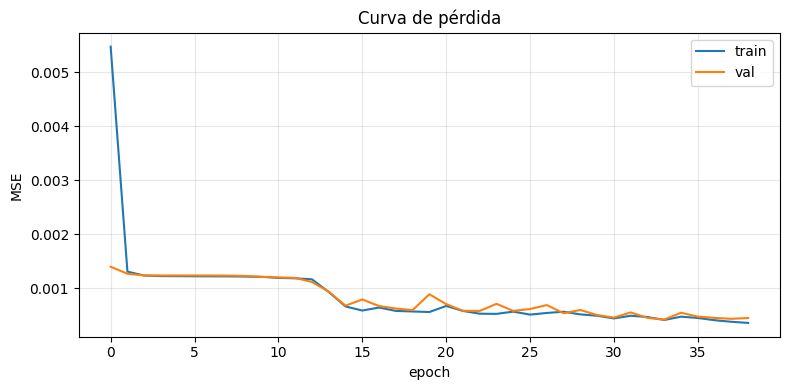

In [43]:
# -----------------------------
# Métricas y utilidades
# -----------------------------
def metrics_np(y_true, y_pred):
    # y_true/pred: (N, L)
    Yt = np.atleast_2d(y_true).astype(np.float64)  # (N, L)
    Yp = np.atleast_2d(y_pred).astype(np.float64)

    flat_t = Yt.ravel()
    flat_p = Yp.ravel()
    mse = mean_squared_error(flat_t, flat_p)
    mae = mean_absolute_error(flat_t, flat_p)
    r2  = r2_score(flat_t, flat_p)
    # Pearson medio por muestra (sin scipy)

    A = Yt - Yt.mean(axis=1, keepdims=True)       # (N, L)
    B = Yp - Yp.mean(axis=1, keepdims=True)       # (N, L)
    num = np.sum(A * B, axis=1)                   # (N,)
    den = np.sqrt(np.sum(A*A, axis=1) * np.sum(B*B, axis=1))  # (N,)

    # Evitar NaN/inf cuando alguna varianza es 0: asigna 0 en esos casos
    cors = np.divide(num, den, out=np.zeros_like(num), where=(den > 0))

    return {
        "MSE": float(f"{mse:.7f}"),
        "MAE": float(f"{mae:.7f}"),
        "R2": float(f"{r2:.6f}"),
        "Pearson(mean)": float(f"{np.mean(cors):.6f}")}

# -----------------------------
# Evaluación en TEST (nunca visto)
# -----------------------------
model.eval()
Yt_list, Yp_list = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE, non_blocking=True).float()
        yb = yb.to(DEVICE, non_blocking=True).float()
        yhat = model(xb)
        Yt_list.append(yb.cpu().numpy())   # (B, L, 1)
        Yp_list.append(yhat.cpu().numpy()) # (B, L, 1)

Y_true = np.concatenate(Yt_list, axis=0)[:, :, 0]
Y_pred = np.concatenate(Yp_list, axis=0)[:, :, 0]
print("\n== Métricas TEST ==")
print(metrics_np(Y_true, Y_pred))

# (Opcional) Curvas de pérdida
plt.figure(figsize=(8,4))
plt.plot(history["train"], label="train")
plt.plot(history["val"], label="val")
plt.title("Curva de pérdida")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

(32, 304, 1)


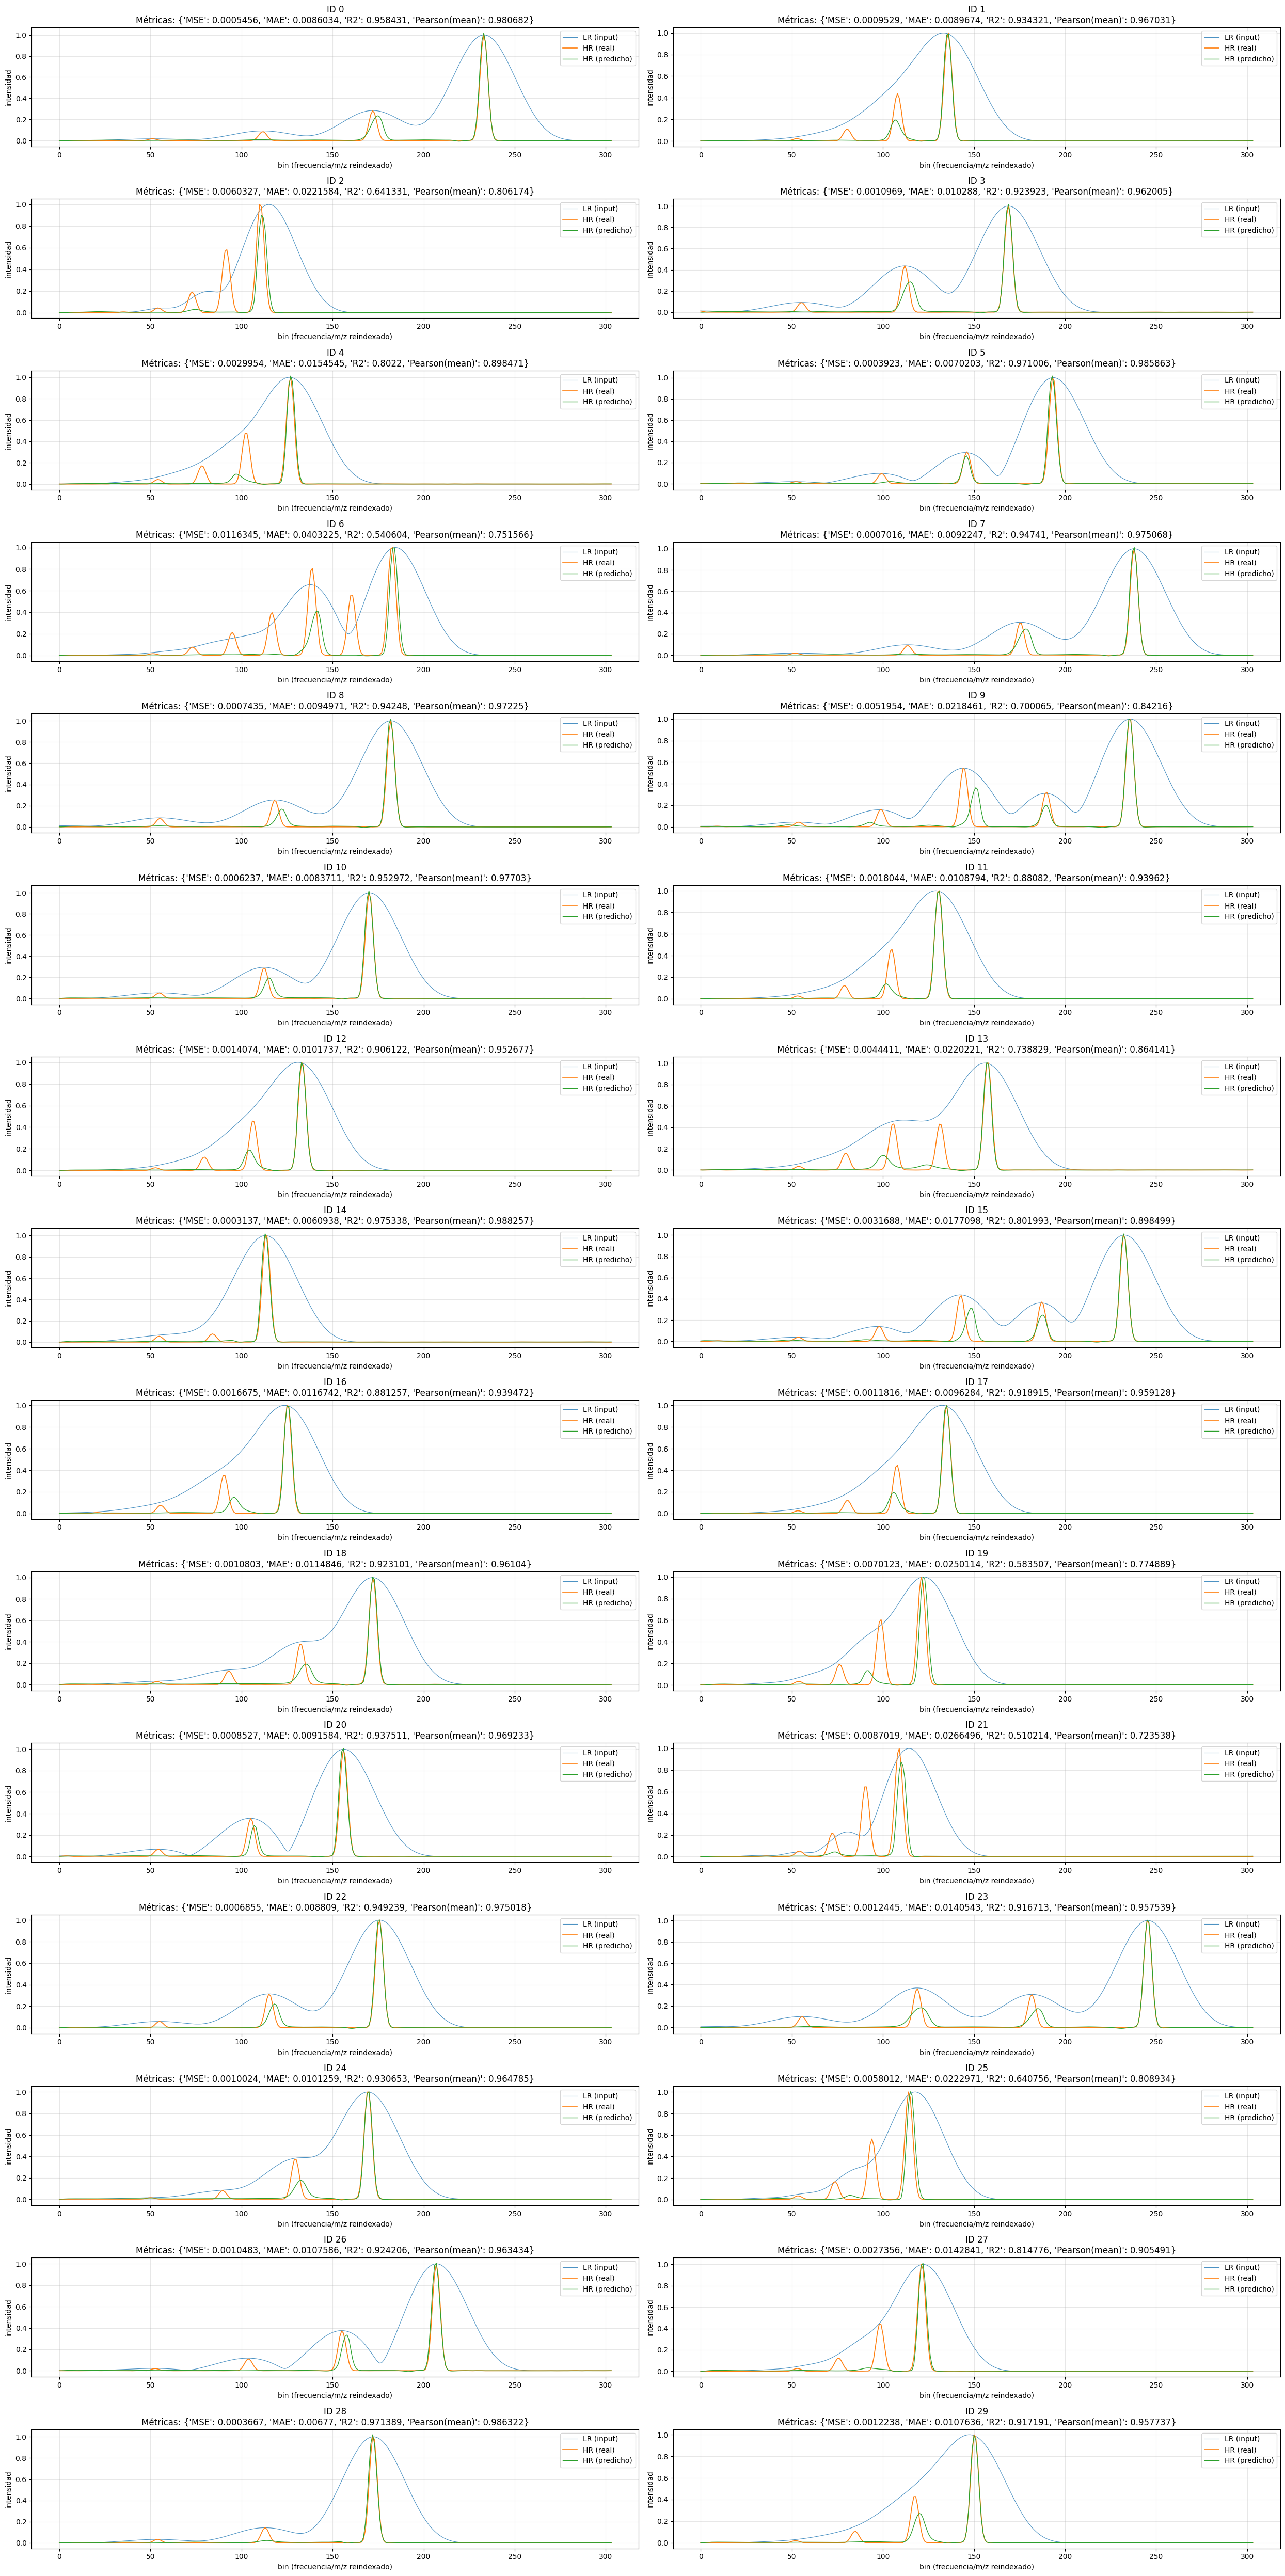

In [44]:
# -----------------------------
# Evaluación en VALIDACIÓN + gráfico
# -----------------------------
# un batch del conjunto de validación o test (modificar la variable test_loader/val_loader) para graficar

model.eval()
xb_val, yb_val = next(iter(test_loader))
with torch.no_grad():
    yhat_val = model(xb_val.to(DEVICE).float()).cpu().numpy()

print(yhat_val.shape)
xb_val = xb_val.numpy()[:, :, 0]  # (B, L)
yb_val = yb_val.numpy()[:, :, 0]  # (B, L)
yhat_val = yhat_val[:, :, 0]      # (B, L)

# Graficar los primeros 25 espectros del batch en una figura de 5x5
n_rows, n_cols = 15, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 50), sharex=False)

for i in range(n_rows * n_cols):


    ax = axes.flat[i]
    ax.plot(xb_val[i, :500], label="LR (input)", linewidth=0.8, alpha=0.8)
    ax.plot(yb_val[i, :500], label="HR (real)", linewidth=1.2)
    ax.plot(yhat_val[i, :500], label="HR (predicho)", linewidth=1.0)
    ax.set_title(f"ID {i}\nMétricas: {metrics_np(yb_val[i], yhat_val[i])}")
    ax.set_ylabel("intensidad")
    ax.grid(alpha=0.3)
    ax.legend()
    ax.set_xlabel("bin (frecuencia/m/z reindexado)")

plt.tight_layout()
plt.show()


In [45]:
!pip install torchinfo



In [46]:
from torchinfo import summary
import torch
summary(model, input_size=(BATCH_SIZE, N_2, 1), dtypes=[torch.float32], col_names=(
    "input_size", "output_size", "num_params", "kernel_size", "mult_adds"
))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
LSTMSeq2Seq                              [32, 304, 1]              [32, 304, 1]              --                        --                        --
├─LSTM: 1-1                              [32, 304, 1]              [32, 304, 256]            529,408                   --                        5,150,081,024
├─AttnBridge: 1-2                        [32, 304, 256]            [32, 304, 128]            --                        --                        --
│    └─Linear: 2-1                       [32, 304, 256]            [32, 304, 128]            32,896                    --                        1,052,672
│    └─ModuleList: 2-6                   --                        --                        (recursive)               --                        --
│    │    └─MultiheadAttention: 3-1      [32, 304, 128]            [32, 304, 128]      